This Jupyter Notebook is used for exploring different problems, and attempts at solving them

# groupby -> resample -> agg

Examining the strange result of using `resample` + `agg` on `groupby`,
stubled upon in [`02-contributors_graph.py`](./02-contributors_graph.py)

In [1]:
import datetime
import json
import logging
import math
import pprint
from collections import Counter, defaultdict
from pathlib import Path
from typing import Optional

# data analysis
import numpy as np
import pandas as pd

# dashboard
import panel as pn

# plotting
from bokeh.models.formatters import DatetimeTickFormatter
import holoviews as hv
import hvplot.pandas
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.figure import Figure
from matplotlib import cm

In [2]:
with open('../../data/examples/stats/qtile.timeline.purpose-to-type.json', mode='r') as json_fp:
    data = json.load(json_fp)

In [3]:
data.keys()

dict_keys(['qtile'])

In [4]:
df = pd.DataFrame.from_records(data['qtile'])
df.shape

(5350, 97)

In [5]:
df = df[df['n_parents'] == 1]
df.shape

(5347, 97)

In [6]:
df = df.dropna(subset=['author.timestamp', 'committer.timestamp'], how='any')
df.shape

(5347, 97)

In [7]:
df = df.assign(
            n_commits =  1,
            author_date    = lambda x: pd.to_datetime(x['author.timestamp'],    unit='s', utc=True),
            committer_date = lambda x: pd.to_datetime(x['committer.timestamp'], unit='s', utc=True),
        )
df.shape

(5347, 100)

In [8]:
df.head(3)

,bug_id,patch_id,file_names,language:Python,type:programming,purpose:programming,+:count,+:type.code,+:purpose.programming,+:type.documentation,...,language:JSON,language:TOML,language:Git Revision List,language:SVG,language:desktop,language:CSS,language:Nix,n_commits,author_date,committer_date
0,all_authors-no_merges,47474a8375ae785b91992355be1678565eba9d23.v2.json,1.0,1.0,1.0,1.0,34.0,30.0,34.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2011-04-11 21:24:27+00:00,2011-04-11 21:24:27+00:00
1,all_authors-no_merges,88197e8de01d79af7858d60acb9bd57bc06b5e73.v2.json,1.0,1.0,1.0,1.0,4.0,4.0,4.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2015-10-20 11:18:55+00:00,2015-10-28 19:36:58+00:00
2,all_authors-no_merges,9f411bf9bcf74c7e28d7eaa0d1fd03c382458ba4.v2.json,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2016-08-12 04:39:33+00:00,2016-08-12 04:39:33+00:00


In [9]:
df.columns

Index(['bug_id', 'patch_id', 'file_names', 'language:Python',
       'type:programming', 'purpose:programming', '+:count', '+:type.code',
       '+:purpose.programming', '+:type.documentation', '-:count',
       '-:type.code', '-:purpose.programming', 'diff.n_files',
       'diff.hunk_span_src', 'diff.hunk_span_dst', 'diff.n_hunks',
       'diff.n_lines_added', 'diff.n_lines_removed', 'diff.n_lines_all',
       'diff.n_rem', 'diff.n_mod', 'diff.n_groups', 'diff.patch_size',
       'diff.n_add', 'diff.hunk_spread_src', 'diff.hunk_spread_dst',
       'diff.groups_spread', 'author.timestamp', 'author.tz_info',
       'author.name', 'author.email', 'committer.timestamp',
       'committer.tz_info', 'committer.name', 'committer.email', 'n_parents',
       '-:type.documentation', 'diff.spread_inner', 'purpose:test',
       '+:type.test', '+:purpose.test', '-:type.test', '-:purpose.test',
       'language:Text', 'type:prose', 'purpose:documentation',
       '+:purpose.documentation', 'languag

In [10]:
df_x = df[['author.email', 'author_date', 'n_commits', '+:count', '-:count']]
df_x

,author.email,author_date,n_commits,+:count,-:count
0,pc@gafol.net,2011-04-11 21:24:27+00:00,1,34.0,4.0
1,nxnfufunezn@gmail.com,2015-10-20 11:18:55+00:00,1,4.0,1.0
2,frostidaho@users.noreply.github.com,2016-08-12 04:39:33+00:00,1,1.0,1.0
3,dev@dariogiovannetti.net,2017-03-18 19:22:58+00:00,1,5.0,2.0
4,mcol@posteo.net,2020-06-10 18:14:23+00:00,1,2.0,1.0
...,...,...,...,...,...
5345,jdulaney@fedoraproject.org,2016-02-02 18:11:46+00:00,1,1.0,1.0
5346,uberj@onid.orst.edu,2012-05-09 06:47:52+00:00,1,1.0,1.0
5347,tycho@tycho.ws,2014-10-08 18:38:30+00:00,1,3.0,3.0
5348,sean.v.775@gmail.com,2015-01-30 01:10:39+00:00,1,52.0,73.0


## Resample only

In [11]:
resample_rate='QE'

In [12]:
agg_func_map={'n_commits': 'sum', '+:count': 'sum', '-:count': 'sum'}
agg_func_map

{'n_commits': 'sum', '+:count': 'sum', '-:count': 'sum'}

In [13]:
columns_agg = list(agg_func_map.keys())
columns_agg

['n_commits', '+:count', '-:count']

In [14]:
df_r = df_x.resample(
        resample_rate,
        on='author_date'
    )[columns_agg].agg(
        agg_func_map,
        numeric_only=True
    )
df_r.shape

(66, 3)

In [15]:
df_r

,n_commits,+:count,-:count
author_date,,,
2008-09-30 00:00:00+00:00,207,8111.0,3487.0
2008-12-31 00:00:00+00:00,73,3730.0,2403.0
2009-03-31 00:00:00+00:00,164,3330.0,1181.0
2009-06-30 00:00:00+00:00,1,1.0,2.0
2009-09-30 00:00:00+00:00,6,323.0,632.0
...,...,...,...
2023-12-31 00:00:00+00:00,107,2004.0,1202.0
2024-03-31 00:00:00+00:00,66,2385.0,540.0
2024-06-30 00:00:00+00:00,128,5381.0,1753.0


## Groupby, then resample

In [16]:
df_g = df_x.groupby('author.email')
df_g

In [17]:
df_g[columns_agg].agg(
        agg_func_map,
        numeric_only=True
    )

,n_commits,+:count,-:count
author.email,,,
0002e7@gmail.com,1,25.0,13.0
1024369+holocronweaver@users.noreply.github.com,1,125.0,2.0
104843199+jlcoulter@users.noreply.github.com,2,2.0,2.0
107062289+shyguyCreate@users.noreply.github.com,10,690.0,81.0
110528300+c0rydoras@users.noreply.github.com,1,27.0,12.0
...,...,...,...
yonnji@kitsune.one,1,82.0,0.0
yurilxc@gmail.com,1,13.0,4.0
zaheen.jamil@gmail.com,2,3.0,1.0


In [18]:
df_x.groupby('author.email').resample(
        resample_rate,
        on='author_date'
    )[columns_agg].agg(
        agg_func_map,
        numeric_only=True
    )

n_commits  \
                                                                          n_commits   
author.email                                    author_date                           
0002e7@gmail.com                                2023-09-30 00:00:00+00:00         1   
1024369+holocronweaver@users.noreply.github.com 2024-12-31 00:00:00+00:00         1   
104843199+jlcoulter@users.noreply.github.com    2022-09-30 00:00:00+00:00         2   
107062289+shyguyCreate@users.noreply.github.com 2024-06-30 00:00:00+00:00         5   
                                                2024-09-30 00:00:00+00:00         3   
...                                                                             ...   
zordsdavini@gmail.com                           2021-03-31 00:00:00+00:00         1   
                                                2021-06-30 00:00:00+00:00         0   
                                                2021-09-30 00:00:00+00:00         0   
                                                2021-12-31 00:00:00+00:00         1   
zwork101@gmail.com                              2024-06-30 00:00:00+00:00         1   

                                                                                   \
                                                                          +:count   
author.email                                    author_date                         
0002e7@gmail.com                                2023-09-30 00:00:00+00:00    25.0   
1024369+holocronweaver@users.noreply.github.com 2024-12-31 00:00:00+00:00   125.0   
104843199+jlcoulter@users.noreply.github.com    2022-09-30 00:00:00+00:00     2.0   
107062289+shyguyCreate@users.noreply.github.com 2024-06-30 00:00:00+00:00    93.0   
                                                2024-09-30 00:00:00+00:00   563.0   
...                                                                           ...   
zordsdavini@gmail.com                           2021-03-31 00:00:00+00:00     1.0   
                                                2021-06-30 00:00:00+00:00     0.0   
                                                2021-09-30 00:00:00+00:00     0.0   
                                                2021-12-31 00:00:00+00:00    14.0   
zwork101@gmail.com                              2024-06-30 00:00:00+00:00     2.0   

                                                                                   \
                                                                          -:count   
author.email                                    author_date                         
0002e7@gmail.com                                2023-09-30 00:00:00+00:00    13.0   
1024369+holocronweaver@users.noreply.github.com 2024-12-31 00:00:00+00:00     2.0   
104843199+jlcoulter@users.noreply.github.com    2022-09-30 00:00:00+00:00     2.0   
107062289+shyguyCreate@users.noreply.github.com 2024-06-30 00:00:00+00:00    41.0   
                                                2024-09-30 00:00:00+00:00    25.0   
...                                                                           ...   
zordsdavini@gmail.com                           2021-03-31 00:00:00+00:00     1.0   
                                                2021-06-30 00:00:00+00:00     0.0   
                                                2021-09-30 00:00:00+00:00     0.0   
                                                2021-12-31 00:00:00+00:00     0.0   
zwork101@gmail.com                              2024-06-30 00:00:00+00:00     1.0   

                                                                            +:count  \
                                                                          n_commits   
author.email                                    author_date                           
0002e7@gmail.com                                2023-09-30 00:00:00+00:00         1   
1024369+holocronweaver@users.noreply.github.com 2024-12-31 00:00:00+00:00         1   
104843199+jlcoulter@users.noreply.gith

In [19]:
df_g_r = df_g.resample(
        resample_rate,
        on='author_date'
    )[columns_agg].agg(
        agg_func_map,
        numeric_only=True
    )
df_g_r.shape

(1165, 9)

In [20]:
df_g_r

n_commits  \
                                                                          n_commits   
author.email                                    author_date                           
0002e7@gmail.com                                2023-09-30 00:00:00+00:00         1   
1024369+holocronweaver@users.noreply.github.com 2024-12-31 00:00:00+00:00         1   
104843199+jlcoulter@users.noreply.github.com    2022-09-30 00:00:00+00:00         2   
107062289+shyguyCreate@users.noreply.github.com 2024-06-30 00:00:00+00:00         5   
                                                2024-09-30 00:00:00+00:00         3   
...                                                                             ...   
zordsdavini@gmail.com                           2021-03-31 00:00:00+00:00         1   
                                                2021-06-30 00:00:00+00:00         0   
                                                2021-09-30 00:00:00+00:00         0   
                                                2021-12-31 00:00:00+00:00         1   
zwork101@gmail.com                              2024-06-30 00:00:00+00:00         1   

                                                                                   \
                                                                          +:count   
author.email                                    author_date                         
0002e7@gmail.com                                2023-09-30 00:00:00+00:00    25.0   
1024369+holocronweaver@users.noreply.github.com 2024-12-31 00:00:00+00:00   125.0   
104843199+jlcoulter@users.noreply.github.com    2022-09-30 00:00:00+00:00     2.0   
107062289+shyguyCreate@users.noreply.github.com 2024-06-30 00:00:00+00:00    93.0   
                                                2024-09-30 00:00:00+00:00   563.0   
...                                                                           ...   
zordsdavini@gmail.com                           2021-03-31 00:00:00+00:00     1.0   
                                                2021-06-30 00:00:00+00:00     0.0   
                                                2021-09-30 00:00:00+00:00     0.0   
                                                2021-12-31 00:00:00+00:00    14.0   
zwork101@gmail.com                              2024-06-30 00:00:00+00:00     2.0   

                                                                                   \
                                                                          -:count   
author.email                                    author_date                         
0002e7@gmail.com                                2023-09-30 00:00:00+00:00    13.0   
1024369+holocronweaver@users.noreply.github.com 2024-12-31 00:00:00+00:00     2.0   
104843199+jlcoulter@users.noreply.github.com    2022-09-30 00:00:00+00:00     2.0   
107062289+shyguyCreate@users.noreply.github.com 2024-06-30 00:00:00+00:00    41.0   
                                                2024-09-30 00:00:00+00:00    25.0   
...                                                                           ...   
zordsdavini@gmail.com                           2021-03-31 00:00:00+00:00     1.0   
                                                2021-06-30 00:00:00+00:00     0.0   
                                                2021-09-30 00:00:00+00:00     0.0   
                                                2021-12-31 00:00:00+00:00     0.0   
zwork101@gmail.com                              2024-06-30 00:00:00+00:00     1.0   

                                                                            +:count  \
                                                                          n_commits   
author.email                                    author_date                           
0002e7@gmail.com                                2023-09-30 00:00:00+00:00         1   
1024369+holocronweaver@users.noreply.github.com 2024-12-31 00:00:00+00:00         1   
104843199+jlcoulter@users.noreply.gith

In [21]:
df_gr = df_x.groupby(['author.email', pd.Grouper(key='author_date', freq=resample_rate)])
df_gr

In [22]:
df_gr[columns_agg].agg(
        agg_func_map,
        numeric_only=True
    )

n_commits  \
author.email                                    author_date                            
0002e7@gmail.com                                2023-09-30 00:00:00+00:00          1   
1024369+holocronweaver@users.noreply.github.com 2024-12-31 00:00:00+00:00          1   
104843199+jlcoulter@users.noreply.github.com    2022-09-30 00:00:00+00:00          2   
107062289+shyguyCreate@users.noreply.github.com 2024-06-30 00:00:00+00:00          5   
                                                2024-09-30 00:00:00+00:00          3   
...                                                                              ...   
zordsdavini@gmail.com                           2020-06-30 00:00:00+00:00         12   
                                                2020-09-30 00:00:00+00:00          1   
                                                2021-03-31 00:00:00+00:00          1   
                                                2021-12-31 00:00:00+00:00          1   
zwork101@gmail.com                              2024-06-30 00:00:00+00:00          1   

                                                                           +:count  \
author.email                                    author_date                          
0002e7@gmail.com                                2023-09-30 00:00:00+00:00     25.0   
1024369+holocronweaver@users.noreply.github.com 2024-12-31 00:00:00+00:00    125.0   
104843199+jlcoulter@users.noreply.github.com    2022-09-30 00:00:00+00:00      2.0   
107062289+shyguyCreate@users.noreply.github.com 2024-06-30 00:00:00+00:00     93.0   
                                                2024-09-30 00:00:00+00:00    563.0   
...                                                                            ...   
zordsdavini@gmail.com                           2020-06-30 00:00:00+00:00    715.0   
                                                2020-09-30 00:00:00+00:00     31.0   
                                                2021-03-31 00:00:00+00:00      1.0   
                                                2021-12-31 00:00:00+00:00     14.0   
zwork101@gmail.com                              2024-06-30 00:00:00+00:00      2.0   

                                                                           -:count  
author.email                                    author_date                         
0002e7@gmail.com                                2023-09-30 00:00:00+00:00     13.0  
1024369+holocronweaver@users.noreply.github.com 2024-12-31 00:00:00+00:00      2.0  
104843199+jlcoulter@users.noreply.github.com    2022-09-30 00:00:00+00:00      2.0  
107062289+shyguyCreate@users.noreply.github.com 2024-06-30 00:00:00+00:00     41.0  
                                                2024-09-30 00:00:00+00:00     25.0  
...                                                                            ...  
zordsdavini@gmail.com                           2020-06-30 00:00:00+00:00     95.0  
                                                2020-09-30 00:00:00+00:00     22.0  
                                                2021-03-31 00:00:00+00:00      1.0  
                                                2021-12-31 00:00:00+00:00      0.0  
zwork101@gmail.com                              2024-06-30 00:00:00+00:00      1.0  

[791 rows x 3 columns]

# -/+ plots

In [23]:
DATASET_DIR = 'data/examples/stats'
JSON_FILE = 'tensorflow.timeline.purpose-to-type.json'
JSON_PATH = None

for TOP_DIR in ['', '..', '../..']:
    full_dir  = Path(TOP_DIR).joinpath(DATASET_DIR)
    full_path = full_dir.joinpath(JSON_FILE)

    if full_dir.is_dir() and full_path.is_file():
        JSON_PATH = full_path
        break

In [24]:
JSON_PATH

PosixPath('../../data/examples/stats/tensorflow.timeline.purpose-to-type.json')

We’ll speed up our application by caching (`@pn.cache`) the data across users

In [25]:
@pn.cache
def get_timeline_data():
    #logger.debug(f"[@pn.cache] get_timeline_data() for {JSON_PATH=}")
    with open(JSON_PATH, mode='r') as json_fp:
        return json.load(json_fp)

In [26]:
timeline_data = get_timeline_data()
type(timeline_data)

dict

In [27]:
timeline_data.keys()

dict_keys(['tensorflow'])

Extract data

In [28]:
tf_timeline_data = timeline_data['tensorflow']

Create `DataFrame` out of timeline data

In [29]:
tf_timeline_df = pd.DataFrame.from_records(tf_timeline_data)
tf_timeline_df.head(5)

,bug_id,patch_id,file_names,language:Python,type:programming,purpose:programming,+:count,+:type.code,+:purpose.programming,+:type.documentation,...,language:INI,language:Limbo,language:Swift,language:JSON,language:OpenStep Property List,language:SVG,language:CSV,language:Dockerfile,diff.n_binary_files,language:MLIR
0,yong.tang,ab0a5278d81ef34096775d5d56f11694cca2a785.v2.json,1.0,1.0,1.0,1.0,38.0,37.0,38.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,yong.tang,2d67d32e587e773811da4577587dc07cf2922641.v2.json,3.0,NaN,1.0,1.0,9.0,1.0,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,yong.tang,6346745f18ded325cdd476d1e521b301b2f38db5.v2.json,1.0,1.0,1.0,1.0,12.0,12.0,12.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,yong.tang,c5121973a96665c5e1420f73e571287f157fa8e3.v2.json,1.0,NaN,1.0,1.0,17.0,15.0,17.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,yong.tang,21a9efc4cddbce661073544db31a63639686310a.v2.json,1.0,NaN,1.0,1.0,2.0,2.0,2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Drop merges and root commits (they have oversized \[first parent] diffs)

In [30]:
tf_timeline_df = tf_timeline_df[tf_timeline_df['n_parents'] == 1]

Add **'n_commits'** column

Before resampling, each row correspons to a single commit

In [31]:
tf_timeline_df['n_commits'] = 1

In [32]:
# Just in case
tf_timeline_df = tf_timeline_df.dropna(subset=['author.timestamp', 'committer.timestamp'], how='any')

In [33]:
tf_timeline_df[['bug_id', 'patch_id', 'author.timestamp', 'author.tz_info', 'committer.timestamp', 'committer.tz_info']]

,bug_id,patch_id,author.timestamp,author.tz_info,committer.timestamp,committer.tz_info
0,yong.tang,ab0a5278d81ef34096775d5d56f11694cca2a785.v2.json,1.570260e+09,+0000,1.570260e+09,+0000
1,yong.tang,2d67d32e587e773811da4577587dc07cf2922641.v2.json,1.520546e+09,+0000,1.552328e+09,+0000
2,yong.tang,6346745f18ded325cdd476d1e521b301b2f38db5.v2.json,1.505932e+09,+0000,1.505932e+09,+0000
3,yong.tang,c5121973a96665c5e1420f73e571287f157fa8e3.v2.json,1.527621e+09,+0000,1.527623e+09,+0000
4,yong.tang,21a9efc4cddbce661073544db31a63639686310a.v2.json,1.511876e+09,-0800,1.519498e+09,+0000
...,...,...,...,...,...,...
3339,ezhulenev,b67cf30e4f7985598846462896e5a1e1591b3b8f.v2.json,1.652739e+09,-0700,1.652739e+09,-0700
3340,ezhulenev,52c5795ccd2a53871bb4edbc136033caef64d3a2.v2.json,1.642784e+09,-0800,1.642784e+09,-0800
3341,ezhulenev,cc579007fec72159cd5d457b8f977a28ff169069.v2.json,1.696482e+09,-0700,1.696482e+09,-0700
3342,ezhulenev,809237b3ff80f99a610f9bc56179057bf5ef391b.v2.json,1.701981e+09,-0800,1.701982e+09,-0800


Create `pd.Timestamp` columns out of timestamp; because they all have to be in the same timezone, use UTC timezone

In [34]:
tf_timeline_df['author.date'] = tf_timeline_df[['author.timestamp', 'author.tz_info']].apply(
    lambda x: pd.Timestamp.fromtimestamp(x['author.timestamp'], tz='UTC'),
axis='columns').astype('datetime64[ns, UTC]')

tf_timeline_df['committer.date'] = tf_timeline_df[['committer.timestamp', 'committer.tz_info']].apply(
    lambda x: pd.Timestamp.fromtimestamp(x['committer.timestamp'], tz='UTC'),
axis='columns').astype('datetime64[ns, UTC]')

In [35]:
tf_timeline_df[['bug_id', 'patch_id', 'author.date', 'author.timestamp', 'author.tz_info']]

,bug_id,patch_id,author.date,author.timestamp,author.tz_info
0,yong.tang,ab0a5278d81ef34096775d5d56f11694cca2a785.v2.json,2019-10-05 07:18:42+00:00,1.570260e+09,+0000
1,yong.tang,2d67d32e587e773811da4577587dc07cf2922641.v2.json,2018-03-08 21:57:07+00:00,1.520546e+09,+0000
2,yong.tang,6346745f18ded325cdd476d1e521b301b2f38db5.v2.json,2017-09-20 18:22:35+00:00,1.505932e+09,+0000
3,yong.tang,c5121973a96665c5e1420f73e571287f157fa8e3.v2.json,2018-05-29 19:10:48+00:00,1.527621e+09,+0000
4,yong.tang,21a9efc4cddbce661073544db31a63639686310a.v2.json,2017-11-28 13:28:49+00:00,1.511876e+09,-0800
...,...,...,...,...,...
3339,ezhulenev,b67cf30e4f7985598846462896e5a1e1591b3b8f.v2.json,2022-05-16 22:11:06+00:00,1.652739e+09,-0700
3340,ezhulenev,52c5795ccd2a53871bb4edbc136033caef64d3a2.v2.json,2022-01-21 16:52:52+00:00,1.642784e+09,-0800
3341,ezhulenev,cc579007fec72159cd5d457b8f977a28ff169069.v2.json,2023-10-05 04:57:01+00:00,1.696482e+09,-0700
3342,ezhulenev,809237b3ff80f99a610f9bc56179057bf5ef391b.v2.json,2023-12-07 20:35:04+00:00,1.701981e+09,-0800


In [36]:
pm_count_cols = [col for col in tf_timeline_df.columns if col.startswith('+:') or col.startswith('-:')]
pm_count_cols.sort(key=lambda s: s[2:]+('0' if s[0] == '-' else '1'))
pm_count_cols

['-:count',
 '+:count',
 '-:purpose.data',
 '+:purpose.data',
 '-:purpose.documentation',
 '+:purpose.documentation',
 '-:purpose.markup',
 '+:purpose.markup',
 '-:purpose.other',
 '+:purpose.other',
 '-:purpose.programming',
 '+:purpose.programming',
 '-:purpose.project',
 '+:purpose.project',
 '-:purpose.test',
 '+:purpose.test',
 '-:type.code',
 '+:type.code',
 '-:type.data',
 '+:type.data',
 '-:type.documentation',
 '+:type.documentation',
 '-:type.markup',
 '+:type.markup',
 '-:type.other',
 '+:type.other',
 '-:type.project',
 '+:type.project',
 '-:type.test',
 '+:type.test']

In [37]:
diff_x_cols = [col for col in tf_timeline_df.columns if col.startswith('diff.')]
diff_x_cols

['diff.n_files',
 'diff.hunk_span_src',
 'diff.hunk_span_dst',
 'diff.n_hunks',
 'diff.n_lines_added',
 'diff.n_lines_removed',
 'diff.n_lines_all',
 'diff.spread_inner',
 'diff.n_add',
 'diff.n_groups',
 'diff.n_mod',
 'diff.patch_size',
 'diff.groups_spread',
 'diff.hunk_spread_src',
 'diff.hunk_spread_dst',
 'diff.n_file_renames',
 'diff.n_rem',
 'diff.n_added_files',
 'diff.n_removed_files',
 'diff.n_binary_files']

In [38]:
#@pn.cache
def resample_timeline(author: str = 'ezhulenev', resample_rate: str = 'ME', agg_func: str = 'sum') -> pd.DataFrame:
    ## DEBUG
    #print(f"> resampling for {author} at sample rate '{resample_rate}' and agg_func '{agg_func}'")
    df = tf_timeline_df[tf_timeline_df['bug_id'] == author].resample(
        resample_rate,
        on='author.date'
    )[['n_commits', *pm_count_cols, *diff_x_cols]].agg(
        {col: agg_func if col in [*pm_count_cols, *diff_x_cols] else 'sum'  # excludes 'n_commits'
         for col in ['n_commits', *pm_count_cols, *diff_x_cols]},
        numeric_only=True
    )

    # to be possibly used for xlabel when plotting
    df['author.date(UTC)'] = df.index
    df['author.date(Y-m)'] = df.index.strftime('%Y-%m')

    # TODO: do it with dependencies / bound functions
    # NOTE: Panel specific !!!
    #column_base_widget.disabled_options = all_possible_pm_col_perc_basenames
    #logger.debug(f"resample_timeline({author=}, {resample_rate=}, {agg_func=}) -> pd.DataFrame({hex(id(df))})")

    return df

In [39]:
tf_timeline_selected_resampled_df = resample_timeline()
tf_timeline_selected_resampled_df.head(5)

,n_commits,-:count,+:count,-:purpose.data,+:purpose.data,-:purpose.documentation,+:purpose.documentation,-:purpose.markup,+:purpose.markup,-:purpose.other,...,diff.groups_spread,diff.hunk_spread_src,diff.hunk_spread_dst,diff.n_file_renames,diff.n_rem,diff.n_added_files,diff.n_removed_files,diff.n_binary_files,author.date(UTC),author.date(Y-m)
author.date,,,,,,,,,,,,,,,,,,,,,
2018-06-30 00:00:00+00:00,8,362.0,2067.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,10883.0,10546.0,10546.0,0.0,295.0,4.0,0.0,0.0,2018-06-30 00:00:00+00:00,2018-06
2018-07-31 00:00:00+00:00,2,4.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,365.0,340.0,340.0,0.0,1.0,0.0,0.0,0.0,2018-07-31 00:00:00+00:00,2018-07
2018-08-31 00:00:00+00:00,2,14.0,543.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,228.0,204.0,204.0,0.0,7.0,2.0,0.0,0.0,2018-08-31 00:00:00+00:00,2018-08
2018-09-30 00:00:00+00:00,18,1363.0,4322.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,13759.0,12491.0,12491.0,0.0,626.0,1.0,0.0,0.0,2018-09-30 00:00:00+00:00,2018-09
2018-10-31 00:00:00+00:00,16,1038.0,2633.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,21685.0,19630.0,19630.0,0.0,418.0,0.0,0.0,0.0,2018-10-31 00:00:00+00:00,2018-10


## Matplotlib

In [40]:
def round_10s(x):
    mult = 10 ** math.floor(math.log10(x))
    return math.ceil(x / mult) * mult

In [41]:
round_10s(277.0)

300

In [42]:
def plot_counts(resampled_df: pd.DataFrame,
                repo_desc: str = 'tensorflow', author_desc: str = 'ezhulenev', resample_rate: str = 'ME', agg_func: str = 'sum',
                figsize: tuple[float, float] = (5, 5),
):
    sns.set_style("whitegrid")

    ## DEBUG figsize
    #print(f"plot_counts(): {figsize=}")
    fig = Figure(figsize=figsize)
    axes = fig.subplots(nrows=2, ncols=1, sharex=True)

    max_count = resampled_df[['+:count', '-:count']].max().max()
    max_ylim = round_10s(max_count)

    for ax, column, color, invert in zip(axes.ravel(), ['+:count', '-:count'], ['green', 'red'], [False, True]):
        sns.lineplot(ax=ax, data=resampled_df, 
                     x='author.date', y=column, 
                     color=color, drawstyle='steps-post')
    
        ax.fill_between(resampled_df.index, resampled_df[column],
                        alpha=0.2, color=color, step='post')
        ax.set_ylim(0, max_ylim)
        ax.set_ylabel(f"{agg_func}({column})")
    
        if invert:
            ax.invert_yaxis()
        else:
            #ax.set_title(f"author={author_desc}", fontsize=9)
            ax.axhline(0, color="k")

    fig.suptitle(f'repo={repo_desc}, author={author_desc}, lines per resample="{resample_rate}"', fontsize=10)
    fig.subplots_adjust(hspace=0)

    #plt.show()
    #plt.close(fig) # CLOSE THE FIGURE!
    return fig

Matplotlib(Figure, tight=True)
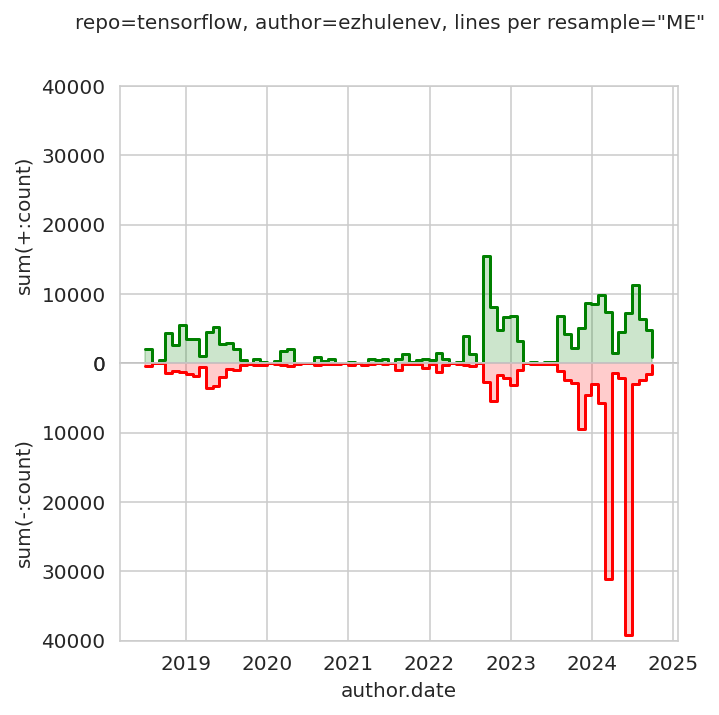

In [43]:
fig = plot_counts(tf_timeline_selected_resampled_df)
pn.pane.Matplotlib(fig, tight=True)

## hvPlot

https://holoviews.org/user_guide/Plotting_with_Matplotlib.html#plot-layouts

> Another aspect that differs quite substantially between matplotlib and other extension is the layout system.
> Since plots do not have an absolute size relative to one another it depends on the aspect of each plot.
> The main options to control the layout include:
>
> - **`aspect_weight`**: Whether to weight the aspect of plots when laying out plots (default=False).
> - **`hspace`**: Horizontal spacing between subplots.
> - **`tight`**: Whether to automatically reduce space between subplots.
> - **`vspace`**: Vertical space between subplots.

> ```python
> line_contours = contours(img).opts(aspect=3)
> fill_contours = filled_contours.opts(aspect=2)
>
> opts.defaults(opts.Layout(sublabel_format='', fig_size=150))
>
> (line_contours + fill_contours).opts(tight=True)
> ```

https://holoviews.org/releases.html#version-1-2-0

> Highlights/features:
> - \[...]
> - New `aspect_weight` and `tight` layout plot options for more customizability of Layout arrangements (4b1f03d, e6a76b7)
> 
> API changes:
> - \[...]
> - Renaming of various plot and style options including:
>    - \[...]
>    - `vertical_spacing` and `horizontal_spacing` to `vspace` and `hspace` respectively

In [44]:
# 'matplotlib' backed supports `vspace` option
hv.opts.Layout(vspace=0.1, backend='matplotlib')

Options('Layout', backend='matplotlib', vspace=0.1)

In [45]:
# but 'bokeh' backend does not support it
#hv.opts.Layout(vspace=0.1, backend='bokeh')

# but there is `border` option for 'bokeh' backend... but not for Layout, but for Curve
#hv.opts.Layout(border=0, backend='bokeh')
hv.opts.Curve(border=0, backend='bokeh')

Options('Curve', backend='bokeh', border=0)

In [46]:
# Check the current backend
current_backend = hv.Store.current_backend
print(f"The current HoloViews backend is: {current_backend}")

The current HoloViews backend is: bokeh


In [56]:
def hvplot_plots(resampled_df: pd.DataFrame,
                 repo_desc: str = 'tensorflow', author_desc: str = 'ezhulenev', resample_rate: str = 'ME', agg_func: str = 'sum',
):
    max_count = resampled_df[['+:count', '-:count']].max().max()
    max_ylim = round_10s(max_count)

    #formatter = DatetimeTickFormatter(months='%Y')
    
    step_p = resampled_df.hvplot.step(
        y="+:count",
        #label="sum(+:count)",
        ylabel=f"{agg_func}(+:count)",
        color="green",
        line_width=3,
        ylim=(0, max_ylim),
        grid=True,
        padding=(0.02,0),
        #xformatter=formatter,
        # step specific
        where='post',
        # interactive
        tools=[
            'box_zoom',
            'save',
            'reset',
            'hover',
        ],
    ).opts(
        xaxis=None,
        default_tools=[], toolbar='above',
        border=1,  # Bohek specific
    )

    step_m = resampled_df.hvplot.step(
        y="-:count",
        #label="sum(-:count)",
        ylabel=f"{agg_func}(-:count)",
        color="red",
        line_width=3,
        ylim=(0, max_ylim),
        grid=True,
        padding=(0.02,0),
        #xformatter=formatter,
        # step specific
        where='post',
        # interactive
        tools=[
            'box_zoom',
            'save',
            'reset',
            'hover',
        ],
    ).opts(
        xaxis='bottom', invert_yaxis=True,
        default_tools=[], toolbar='above',
        border=1,  # Bohek specific
    )  # Invert the y-axis

    return (step_p, step_m)

In [57]:
def hvplot_counts(resampled_df: pd.DataFrame,
                 repo_desc: str = 'tensorflow', author_desc: str = 'ezhulenev', resample_rate: str = 'ME', agg_func: str = 'sum',
):
    (step_p, step_m) = hvplot_plots(
        resampled_df=resampled_df,
        repo_desc=repo_desc, author_desc=author_desc, resample_rate=resample_rate, agg_func=agg_func,
    )
    
    return (step_p + step_m).opts(
        #vspace=0,  # not for Bokeh backend
        #tight=True,  # not for Bokeh backend
        title=f'repo={repo_desc}, author={author_desc}, lines per resample="{resample_rate}"',
        fontsize={'title': '10pt'},
    ).cols(1)

In [58]:
def hvplot_overlay(resampled_df: pd.DataFrame,
                   repo_desc: str = 'tensorflow', author_desc: str = 'ezhulenev', resample_rate: str = 'ME', agg_func: str = 'sum',
):
    (step_p, step_m) = hvplot_plots(
        resampled_df=resampled_df,
        repo_desc=repo_desc, author_desc=author_desc, resample_rate=resample_rate, agg_func=agg_func,
    )
    
    return (step_p * step_m).opts(
        #vspace=0,  # not for Bokeh backend
        #tight=True,  # not for Bokeh backend
        title=f'repo={repo_desc}, author={author_desc}, lines per resample="{resample_rate}"',
        fontsize={'title': '10pt'},
    )

In [55]:
fig = hvplot_counts(tf_timeline_selected_resampled_df)
pn.pane.HoloViews(fig)

HoloViews(Layout)

In [61]:
# Does not work as intended, both plots use the same iverted y axis

#fig = hvplot_overlay(tf_timeline_selected_resampled_df)
#pn.pane.HoloViews(fig)

In [63]:
(step_p, step_m) = hvplot_plots(tf_timeline_selected_resampled_df)
print(step_p)

:Curve   [author.date]   (+:count)


In [71]:
dir(step_p)

['_Chart__abstract',
 '_Dimensioned__abstract',
 '_Element2D__abstract',
 '_Element__abstract',
 '_ViewableElement__abstract',
 '__add__',
 '__bool__',
 '__class__',
 '__contains__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lshift__',
 '__lt__',
 '__module__',
 '__mul__',
 '__ne__',
 '__new__',
 '__radd__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_auto_indexable_1d',
 '_auxiliary_component',
 '_binned',
 '_cached',
 '_cached_constants',
 '_conversion_interface',
 '_dataset',
 '_deep_indexable',
 '_dim_aliases',
 '_dim_groups',
 '_empty_region',
 '_get_bounds_selection',
 '_get_index_expr',
 '_get_index_selection',
 '_get_lasso_selection',
 '_get_selection',
 '_get_selection_dims',
 '_

In [220]:
step_p.opts['color']

'green'

In [188]:
step_p.dframe().iloc[:,0].values[:5]

array(['2018-06-30T00:00:00.000000000', '2018-07-31T00:00:00.000000000',
       '2018-08-31T00:00:00.000000000', '2018-09-30T00:00:00.000000000',
       '2018-10-31T00:00:00.000000000'], dtype='datetime64[ns]')

In [113]:
step_p.dimensions

<bound method Dimensioned.dimensions of :Curve   [author.date]   (+:count)>

In [103]:
step_p.dimension_values('+:count', expanded=False, flat=False)

array([2.0670e+03, 2.0000e+01, 5.4300e+02, 4.3220e+03, 2.6330e+03,
       5.4790e+03, 3.5200e+03, 3.5050e+03, 1.0430e+03, 4.5460e+03,
       5.2750e+03, 2.7790e+03, 2.9640e+03, 2.1350e+03, 4.3400e+02,
       4.7000e+01, 6.4100e+02, 2.0500e+02, 3.0000e+01, 2.9700e+02,
       1.7360e+03, 2.1080e+03, 1.2400e+02, 4.2000e+01, 2.3000e+01,
       9.5800e+02, 3.1900e+02, 5.6600e+02, 5.7000e+01, 1.7000e+01,
       2.2200e+02, 8.0000e+00, 6.4600e+02, 5.5400e+02, 6.8800e+02,
       0.0000e+00, 5.7400e+02, 1.3830e+03, 2.0100e+02, 4.6500e+02,
       6.1300e+02, 5.1200e+02, 1.4770e+03, 6.4000e+02, 1.2000e+01,
       2.5500e+02, 3.9410e+03, 1.3770e+03, 1.3000e+01, 1.5431e+04,
       8.1700e+03, 4.8050e+03, 6.6960e+03, 6.8360e+03, 3.2400e+03,
       5.1000e+01, 1.5800e+02, 6.3000e+01, 2.6500e+02, 1.6900e+02,
       6.8810e+03, 4.1860e+03, 2.1680e+03, 5.0730e+03, 8.6550e+03,
       8.5460e+03, 9.8130e+03, 7.3810e+03, 1.5460e+03, 4.5590e+03,
       7.2620e+03, 1.1271e+04, 6.4460e+03, 4.8290e+03, 9.1700e

In [67]:
xs = [1, 2, 3]
ys = [2, 0, 7]
hv.Polygons([{'x': xs, 'y': ys}]).opts(color='red', alpha=0.2)

:Polygons   [x,y]

In [121]:
step_p[:20]

:Curve   [author.date]   (+:count)

In [197]:
str(step_p.dimensions()[0])

'author.date'

In [122]:
xs = step_p[:20].dimension_values('author.date').astype(np.int64)
ys = step_p[:20].dimension_values('+:count')
#hv.Polygons([{'x': xs, 'y': ys}]).opts(color='red', alpha=0.2)

In [152]:
xs_c = np.empty((xs.size + xs.size + 1,), dtype=xs.dtype)
xs_c[0::2] = np.append(xs, [xs[-1]])
xs_c[1::2] = xs

ys_c = np.zeros((ys.size + ys.size + 1,), dtype=ys.dtype)
ys_c[1::2] = ys
ys_c[2::2] = ys

ys_c[-1] = 0

In [153]:
print(f" 0:({xs_c[0]}, {ys_c[0]}")
print(f" 1:({xs_c[1]}, {ys_c[1]}")
print("...")
print(f"-2:({xs_c[-2]}, {ys_c[-2]}")
print(f"-1:({xs_c[-1]}, {ys_c[-1]}")

 0:(1530316800000000000, 0.0
 1:(1530316800000000000, 2067.0
...
-2:(1580428800000000000, 297.0
-1:(1580428800000000000, 0.0


In [157]:
poly = hv.Polygons([{'x': xs_c, 'y': ys_c}]).opts(color='green', alpha=0.2)
poly

:Polygons   [x,y]

In [160]:
#step_p[0:20] * poly

In [162]:
ts = step_p[:20].dimension_values('author.date')
ys = step_p[:20].dimension_values('+:count')

ts[:3]

array(['2018-06-30T00:00:00.000000000', '2018-07-31T00:00:00.000000000',
       '2018-08-31T00:00:00.000000000'], dtype='datetime64[ns]')

In [163]:
ts_x = np.empty((ts.size + ts.size + 1,), dtype=ts.dtype)
ts_x[0::2] = np.append(ts, [ts[-1]])
ts_x[1::2] = ts

ys_x = np.zeros((ys.size + ys.size + 1,), dtype=ys.dtype)
ys_x[1::2] = ys
ys_x[2::2] = ys

ys_x[-1] = 0

In [167]:
df_area = pd.DataFrame({'author.date': ts_x, '+:count': ys_x})
df_area.head(10)

,author.date,+:count
0,2018-06-30,0.0
1,2018-06-30,2067.0
2,2018-07-31,2067.0
3,2018-07-31,20.0
4,2018-08-31,20.0
5,2018-08-31,543.0
6,2018-09-30,543.0
7,2018-09-30,4322.0
8,2018-10-31,4322.0
9,2018-10-31,2633.0


In [176]:
plot_1 = df_area.hvplot.scatter(x='author.date', y='+:count', color='green', alpha=0.8, size=5, sort_date=False).opts(default_tools=[], tools=["hover"])
plot_2 = df_area.hvplot.area(x='author.date', y='+:count', color='green', alpha=0.2, sort_date=False).opts(default_tools=[], tools=[])

plot_1 * plot_2

:Overlay
   .Scatter.I :Scatter   [author.date]   (+:count)
   .Area.I    :Area   [author.date]   (+:count)

In [178]:
step_p[:20] * plot_2

:Overlay
   .Curve.I :Curve   [author.date]   (+:count)
   .Area.I  :Area   [author.date]   (+:count)

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
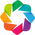

:Overlay
   .Scatter.I  :Scatter   [x]   (y)
   .Scatter.II :Scatter   [x]   (y)

In [190]:
hv.extension("bokeh")
hv.Scatter([]).opts(default_tools=[])*hv.Scatter([]).opts(default_tools=[])

In [191]:
type(step_p)

holoviews.element.chart.Curve

In [192]:
hv.element.chart.Curve

holoviews.element.chart.Curve

In [223]:
def area_step_from_curve(curve: hv.element.chart.Curve,
                         color: str = 'green', alpha: float = 0.2,
                         where: str = 'post'):
    if where != 'post':
        raise ValueError(f"{where=} not supported, possible values are ['post']")

    # extract x and y values
    #ts = curve.dframe().iloc[:,0]
    #ys = curve.dframe().iloc[:,1]
    ts = curve.dimension_values(0)
    ys = curve.dimension_values(1)

    # create step function from those values
    ts_x = np.empty((ts.size + ts.size + 1,), dtype=ts.dtype)
    ts_x[0::2] = np.append(ts, [ts[-1]])
    ts_x[1::2] = ts

    ys_x = np.zeros((ys.size + ys.size + 1,), dtype=ys.dtype)
    ys_x[1::2] = ys
    ys_x[2::2] = ys

    ys_x[-1] = 0

    # create DataFrame (alternative would be to create xarray)
    df = pd.DataFrame({
        str(step_p.dimensions()[0]): ts_x,
        str(step_p.dimensions()[1]): ys_x,
    })

    plot = df.hvplot.area(
        x=str(step_p.dimensions()[0]),
        y=str(step_p.dimensions()[1]),
        # options from parameters
        color=color,
        alpha=alpha,
        # needed to work correctly
        sort_date=False,
        # hover does not work for area
        tools=[],
        hover=False,
    ).opts(default_tools=[])

    return plot

In [209]:
step_p * area_step_from_curve(step_p, color='green')

:Overlay
   .Curve.I :Curve   [author.date]   (+:count)
   .Area.I  :Area   [author.date]   (+:count)

In [210]:
step_m * area_step_from_curve(step_m, color='red')

:Overlay
   .Curve.I :Curve   [author.date]   (-:count)
   .Area.I  :Area   [author.date]   (+:count)

In [211]:
(step_p * area_step_from_curve(step_p, color='green') + step_m * area_step_from_curve(step_m, color='red')).cols(1)

:Layout
   .Overlay.I  :Overlay
      .Curve.I :Curve   [author.date]   (+:count)
      .Area.I  :Area   [author.date]   (+:count)
   .Overlay.II :Overlay
      .Curve.I :Curve   [author.date]   (-:count)
      .Area.I  :Area   [author.date]   (+:count)

In [221]:
def hvplot_pm_counts(
    resampled_df: pd.DataFrame,
    repo_desc: str = 'tensorflow', author_desc: str = 'ezhulenev', resample_rate: str = 'ME', agg_func: str = 'sum',
):
    (step_p, step_m) = hvplot_plots(
        resampled_df=resampled_df,
        repo_desc=repo_desc, author_desc=author_desc, resample_rate=resample_rate, agg_func=agg_func,
    )

    area_p = area_step_from_curve(step_p, color=step_p.opts['color'])
    area_m = area_step_from_curve(step_m, color=step_m.opts['color'])
    
    return (step_p*area_p + step_m*area_m).opts(
        #vspace=0,  # not for Bokeh backend
        #tight=True,  # not for Bokeh backend
        title=f'repo={repo_desc}, author={author_desc}, lines per resample="{resample_rate}"',
        fontsize={'title': '10pt'},
    ).cols(1)

In [232]:
step_p * hv.HLine(0.0).opts(color='gray', line_width=3)

:Overlay
   .Curve.I :Curve   [author.date]   (+:count)
   .HLine.I :HLine   [x,y]

In [224]:
fig = hvplot_pm_counts(tf_timeline_selected_resampled_df)
pn.pane.HoloViews(fig)

HoloViews(Layout)

# Sankey - directory structure of changes

## Examples

In [246]:
hv.Sankey([
    ('A', 'X', 5),
    ('A', 'Y', 7),
    ('A', 'Z', 6),
    ('B', 'X', 2),
    ('B', 'Y', 9),
    ('B', 'Z', 4)]
).opts(width=600, height=400)

:Sankey   [start,end]   (Value)

In [251]:
hv.Sankey([
    ('A', 'X', 5),
    ('A', 'Y', 7),
    ('A', 'Z', 6),
    ('A', 'x', 4), # intermediate
    ('x', 'X', 2), # ...
    ('B', 'X', 2),
    ('B', 'Y', 9),
    ('B', 'Z', 4)]
).opts(width=600, height=400)

:Sankey   [start,end]   (Value)

## Read and process data

In [233]:
with open('../../data/examples/stats/qtile.lines-stats.json', mode='r') as json_fp:
    lines_data = json.load(json_fp)

In [235]:
lines_data.keys()

dict_keys(['data/examples/annotations/qtile'])

In [236]:
lines_data['data/examples/annotations/qtile'].keys()

dict_keys(['all_authors-no_merges'])

In [242]:
elem = next(iter(lines_data['data/examples/annotations/qtile']['all_authors-no_merges'].values()))
elem

{'libqtile/layout/tree.py': {'language': 'Python',
  'type': 'programming',
  'purpose': 'programming',
  '+': {'count': 34,
   'type.code': 30,
   'purpose.programming': 34,
   'type.documentation': 4},
  '-': {'count': 4, 'type.code': 4, 'purpose.programming': 4},
  '+/-': {'type.code': 34,
   'purpose.programming': 38,
   'type.documentation': 4}}}

In [244]:
{k: k.split('/') for k in elem.keys()}

{'libqtile/layout/tree.py': ['libqtile', 'layout', 'tree.py']}

# hvPlot / HoloViews help

In [49]:
hvplot.help('step')


The `step` plot connects the points with piece-wise constant curves.

The `step` plot can be used pretty much anytime the `line` plot might be used, and has many
of the same options available.

Reference: https://hvplot.holoviz.org/reference/tabular/step.html

Parameters
----------
x : string, optional
    Field name(s) to draw x-positions from. If not specified, the index is
    used. Must refer to continuous data. Not categorical data.
y : string or list, optional
    Field name(s) to draw y-positions from. If not specified, all numerical
    fields are used.
by : string, optional
    A single field or list of fields to group by. All the subgroups are visualized.
groupby: string, list, optional
    A single field or list of fields to group and filter by. Adds one or more widgets to
    select the subgroup(s) to visualize.
where: string, optional
    The interpolation method. One of 'mid', 'pre', 'post'. Default is 'mid'.
color : str or array-like, optional.
    The color for each of

In [51]:
hvplot.help('area')


The `area` plot can be used to color the area under a line or to color the space between two
lines.

Reference: https://hvplot.holoviz.org/reference/tabular/area.html

Parameters
----------
x : string, optional
    Field name(s) to draw x-positions from. If not specified, the index is
    used. Can refer to continuous and categorical data.
y : string, optional
    Field name to draw the first y-position from
y2 : string, optional
    Field name to draw the second y-position from
stacked : boolean, optional
    Whether to stack multiple areas. Default is False.
**kwds : optional
    Additional keywords arguments are documented in `hvplot.help('area')`.

Returns
-------
A Holoviews object. You can `print` the object to study its composition and run

.. code-block::

    import holoviews as hv
    hv.help(the_holoviews_object)

to learn more about its parameters and options.

Example
-------

.. code-block::

    import hvplot.pandas
    import pandas as pd

    df = pd.DataFrame(
      

In [50]:
help(hv.Layout)

Help on class Layout in module holoviews.core.layout:

class Layout(Layoutable, holoviews.core.dimension.ViewableTree)
 |  Layout(items=None, identifier=None, parent=None, **kwargs)
 |
 |      A Layout is an ViewableTree with ViewableElement objects as leaf
 |      values. Unlike ViewableTree, a Layout supports a rich display,
 |      displaying leaf items in a grid style layout. In addition to the
 |      usual ViewableTree indexing, Layout supports indexing of items by
 |      their row and column index in the layout.
 |
 |      The maximum number of columns in such a layout may be controlled
 |      with the cols method.
 |
 |  Parameters of 'Layout'
 |  ======================
 |  
 |  Parameters changed from their default values are marked in red.
 |  Soft bound values are marked in cyan.
 |  C/V= Constant/Variable, RO/RW = ReadOnly/ReadWrite, AN=Allow None
 |
 |  Name     Value     Type     Bounds   Mode 
 |
 |  group   'Layout'  String             C RW
 |  label      ''     Strin

In [69]:
hv.help(hv.Area)

Area

Online example: https://holoviews.org/reference/elements/bokeh/Area.html

-------------
Style Options
-------------

	alpha, color, fill_alpha, fill_color, hover_alpha, hover_color, hover_fill_alpha, hover_fill_color, hover_line_alpha, hover_line_cap, hover_line_color, hover_line_dash, hover_line_dash_offset, hover_line_join, hover_line_width, line_alpha, line_cap, line_color, line_dash, line_dash_offset, line_join, line_width, muted, muted_alpha, muted_color, muted_fill_alpha, muted_fill_color, muted_line_alpha, muted_line_cap, muted_line_color, muted_line_dash, muted_line_dash_offset, muted_line_join, muted_line_width, nonselection_alpha, nonselection_color, nonselection_fill_alpha, nonselection_fill_color, nonselection_line_alpha, nonselection_line_cap, nonselection_line_color, nonselection_line_dash, nonselection_line_dash_offset, nonselection_line_join, nonselection_line_width, selection_alpha, selection_color, selection_fill_alpha, selection_fill_color, selection_line_alpha

In [70]:
hv.help(hv.Curve)

Curve

Online example: https://holoviews.org/reference/elements/bokeh/Curve.html

-------------
Style Options
-------------

	alpha, color, hover_alpha, hover_color, hover_line_alpha, hover_line_cap, hover_line_color, hover_line_dash, hover_line_dash_offset, hover_line_join, hover_line_width, line_alpha, line_cap, line_color, line_dash, line_dash_offset, line_join, line_width, muted, muted_alpha, muted_color, muted_line_alpha, muted_line_cap, muted_line_color, muted_line_dash, muted_line_dash_offset, muted_line_join, muted_line_width, nonselection_alpha, nonselection_color, nonselection_line_alpha, nonselection_line_cap, nonselection_line_color, nonselection_line_dash, nonselection_line_dash_offset, nonselection_line_join, nonselection_line_width, selection_alpha, selection_color, selection_line_alpha, selection_line_cap, selection_line_color, selection_line_dash, selection_line_dash_offset, selection_line_join, selection_line_width, visible

(Consult bokeh's documentation for more inf